# Событийный анализ пользователей мобильного приложения по продаже продуктов питания

__Цель исследования:__ Анализ поведения пользователей мобильного приложения, который продаёт продукты питания. 

__Задачи исследования:__ исследовать результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

__Данные исследования:__ Данные за два месяца с 2019-07-25 по 2019-08-07 со следующей информацией - 
название события, уникальный идентификатор пользователя, время события и номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

__Выполненные задачи в рамках проекта:__ <br>
- приведены данные к нужным типам;
- найдены и исправлены ошибки в данных;
- изучены и проверены данные по событиям и пользователям, построена гистограмма по количеству событий по дате и времени для определения полноты данных;
- проанализированы воронки продаж для того, чтобы узнать, как пользователи доходят до покупки;
- исследование результатов A/A/B-эксперимента по поводу чувствительности аудитории к изменению в шрифтах;
- применение Z-теста для проверки статистической значимости различий в долях(конверсиях) перехода с одной страницы на другую. 

### Содержание
<ul style="list-style:none; text-decoration: none">
    <li><a style="text-decoration: none" href="#introduction">1. Загрузка данных и подготовка их к анализу</a></li>
    <li><a style="text-decoration: none" href="#data_pre-processing">2. Подготовка данных</a></li>
    <li><a style="text-decoration: none" href="#analysis">3. Анализ воронки событий</a></li>
    <li><a style="text-decoration: none" href="#research_analysis">4. Анализ результатов эксперимента.</a></li>
    <li><a style="text-decoration: none" href="#conclusion">5. Выводы</a></li>
</ul>

## 1.  Загрузка данных и подготовка их к анализу <a name="introduction"></a> 

In [1]:
#Импортирую библиотеку
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import scipy.stats as stats
from plotly import graph_objects as go
import math as mth

Импортирую библиотеку Pandas и с помощью метода .read_csv() создаю новый DataFrame __logs_exp__ 

In [2]:
logs_exp = pd.read_csv('logs_exp.csv', sep='\t')

Создаю функцию для получения основной информации о датафрейме

In [3]:
#пропишем функцию для получения основной информации о датафрейме
def data_describe(dataframe):
    display(dataframe.head(10))
    display(dataframe.describe())
    dataframe.info()
    
#запускаем функцию
data_describe(logs_exp) 

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Проверим на дубликаты таблицу, так как пропусков в таблице нет. При проверке на наличие дубликатов  было найдено 413 дубликатов, которые мы успешно удаляем.

In [4]:
print('\nНайдено пропущенных значений: {}\n'.format(logs_exp.duplicated().sum()))

logs_exp = logs_exp.drop_duplicates().reset_index(drop=True)

len(logs_exp)


Найдено пропущенных значений: 413



243713

Переименуем столбцы и приведем время к нужному.

In [5]:
#Переименовываем столбцы
logs_exp = logs_exp.rename(columns={'EventName': 'eventName',  'DeviceIDHash': 'deviceID', 'EventTimestamp': 'eventTime', 'ExpId': 'expID'})

#Приводим время к нужному.
logs_exp['eventTime'] = logs_exp['eventTime'].astype(int)
logs_exp['eventTime'] = pd.to_datetime(logs_exp['eventTime'], unit='s')

#Проверяем таблицу
logs_exp.head()

,eventName,deviceID,eventTime,expID
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248


__Вывод:__<br>
Полученная таблица содержит в себе информацию о действиях пользователей приложений мобильного приложения, который продаёт продукты питания. В рамках работы с полученными таблицами были приведены название данных с кафе к нижнему реестру. В таблице отсутствуют пропущенные значения, но в тоже время найдены 413 дубликата, которые были удалены.

## 2. Подготовка данных <a name="data_pre-processing"></a>

Для начало изучим события в логе и сколько пользователей в логе.

In [6]:
print('\nВсего событий в логе: {}\n'.format(logs_exp['deviceID'].count()))
print('\nУникальных событий в логе: {}\n'.format(logs_exp['eventName'].value_counts().count()))
print('\nВыделим следующие события, представленные в лого:\n')
for i in logs_exp['eventName'].unique(): 
    print('   ' + i)
print('\nВсего пользователей в логе: {}\n'.format(logs_exp['deviceID'].value_counts().count()))


Всего событий в логе: 243713


Уникальных событий в логе: 5


Выделим следующие события, представленные в лого:

   MainScreenAppear
   PaymentScreenSuccessful
   CartScreenAppear
   OffersScreenAppear
   Tutorial

Всего пользователей в логе: 7551



Затем рассчитаем сколько в среднем приходится на пользователя.

In [7]:
averageEventPerUser = logs_exp.groupby('deviceID').agg({'eventName': 'count'}).reset_index()

print('На одного пользователя приходится в среднем {:.1f} события'.format(averageEventPerUser['eventName'].mean()))

На одного пользователя приходится в среднем 32.3 события


Найдем максимальную и минимальную дату. Построим гистограмму по дате и времени. 

In [8]:
maxTime = logs_exp['eventTime'].max()
minTime = logs_exp['eventTime'].min()
print('Минимальная дата {}'.format(minTime.date()))
print('Максимальная дата {}'.format(maxTime.date()))
logs_exp['eventData'] = logs_exp['eventTime'].dt.date

Минимальная дата 2019-07-25
Максимальная дата 2019-08-07


Построим гистограмму по дате и времени. Определим, с какого момента данные полные и отбросим более старые. На основе полученной информации можно сделать вывод, что нам нужно отбросить данные до 1 августа, до этого момента данные не полные.

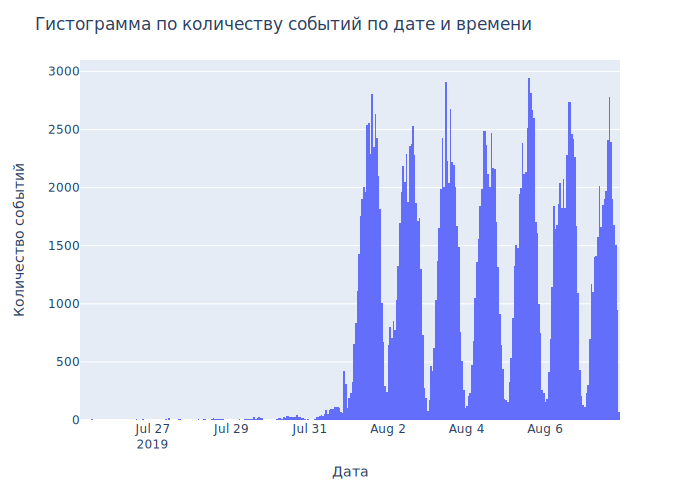

In [9]:
#Группириуем данные по дате 
eventCount = logs_exp.groupby('eventTime').agg({'eventName': 'count'}).reset_index()

#Строим гистограмму
fig = px.histogram(eventCount, x="eventTime", y="eventName")
fig.update_layout(
    title = 'Гистограмма по количеству событий по дате и времени',
    xaxis_title="Дата",
    yaxis_title="Количество событий")
fig.show(renderer='svg')

Делаем срез по таблице, убирая оттуда все данные которые раньше 1 августа 2019 года. Для получения данных приведем __'eventData'__ к нужному типу.

In [10]:
#Приводим 'eventData' к нужному типу.
logs_exp['eventData'] = pd.to_datetime(logs_exp['eventData'])

#Делаем срез по таблице
logsExpNew = logs_exp.query('eventTime >= "2019-08-01"')
logsExpNew.count()
differenceUsers = logs_exp['deviceID'].nunique() - logsExpNew['deviceID'].nunique()
differencePercentUsers = differenceUsers /  logs_exp['deviceID'].nunique() 
differenceEvent = logs_exp['eventName'].count() - logsExpNew['eventName'].count()
differencePercentEvent = differenceEvent /  logsExpNew['eventName'].count() 
print('{} пользователей теряем при данном срезе, что составляет {:.1%}  от общего числа'.format(differenceUsers, differencePercentUsers))
print('{} событий теряем при данном срезе, что составляет {:.1%}  от общего числа'.format(differenceEvent, differencePercentEvent))

17 пользователей теряем при данном срезе, что составляет 0.2%  от общего числа
2826 событий теряем при данном срезе, что составляет 1.2%  от общего числа


Проверим, наличие пользователей из всех трёх экспериментальных групп. Наличие трех групп подтвержается

In [11]:
logs_exp['expID'].value_counts()

248    85582
246    80181
247    77950
Name: expID, dtype: int64

__Выводы:___
представленные данные включают в себя 5 событий и 7551 пользователей. На одного пользователя приходится в среднем 32.3 события.
Представленные данные с 2019-07-25 до 2019-08-07. Построенная гистограмму по дате и времени показала нам, что нужно отбросить данные до 1 августа, так как до этого момента данные не полные. Связано это с тем, что технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные.

## 3. Анализ воронки событий <a name="analysis"></a> 

Посмотрим, какие события есть в логах, как часто они встречаются  с помощью метода __count()__. Исходя из полученных значений, распределились они по частоте согласно следующей последовательности:
* Потенциальные клиенты приходят на сайт;
* Добавляют в корзину товары;
* Оформляют заказ;
* Оплачивают покупку.<br>
При этом у нас есть такое событие __Tutorial__. В данном случае пользатель может при любом наступлении события воспользоваться им. поэтому тяжело его отнести к какой либо последовательности. В целом количество пользователей минимально, которые обращаются к данному событию, поэтому просто избавимся от него, чтобы оно не мешало.<br
Посчитаем количество уникальных людей в каждой группе, при агрегации вызовем метод __nunique__. Сделаем сортировку по убыванию. Затем построим график. 

In [12]:
logsExpNew['eventName'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: eventName, dtype: int64

In [13]:
logsExpNew = logsExpNew.query('eventName != "Tutorial"')

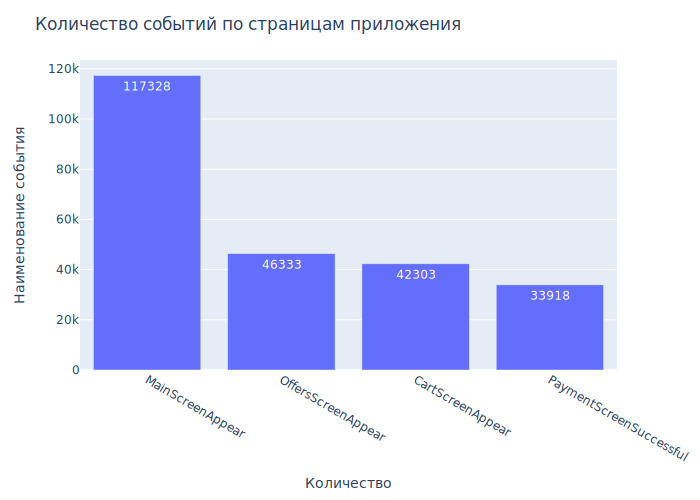

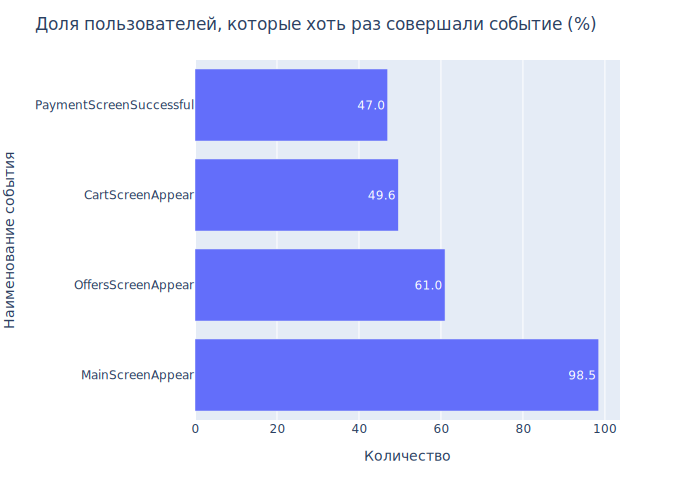

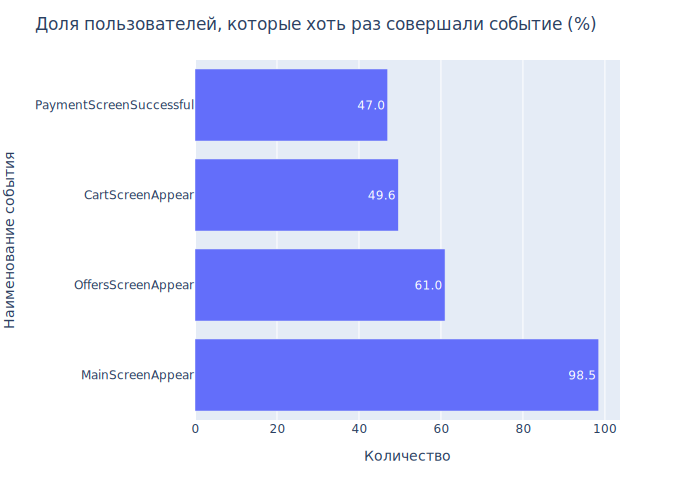

In [14]:
#Посчитаем количество уникальных пользователей и отсортируем данное событие
eventNameCount = logsExpNew.groupby('eventName')['deviceID'].agg(['count', 'nunique']).reset_index().sort_values(by='count', ascending=False)
fig = px.bar(eventNameCount, x ='eventName', y='count', text='count')
fig.update_layout(
    title = 'Количество событий по страницам приложения',
    xaxis_title="Количество",
    yaxis_title="Наименование события")
fig.show(renderer='svg')


#Рассчитаем проценты по доле пользователей, которые хоть раз совершали событие.
eventNameCount['user_share'] = (eventNameCount['nunique'] / logsExpNew['deviceID'].value_counts().count()*100).round(1)
fig = px.bar(eventNameCount, x ='user_share', y='eventName',  orientation='h', text='user_share')
fig.update_layout(
    title = 'Доля пользователей, которые хоть раз совершали событие (%)',
    xaxis_title="Количество",
    yaxis_title="Наименование события")
fig.show(renderer='svg')

#Рассчитаем проценты по доле пользователей, которые хоть раз совершали событие.

fig = px.bar(eventNameCount, x ='user_share', y='eventName',  orientation='h', text='user_share')
fig.update_layout(
    title = 'Доля пользователей, которые хоть раз совершали событие (%)',
    xaxis_title="Количество",
    yaxis_title="Наименование события")
fig.show(renderer='svg')

По продуктовой воронке посчитаем, какая доля пользователей проходит на следующий шаг воронки (не учитывая последовательность событий):

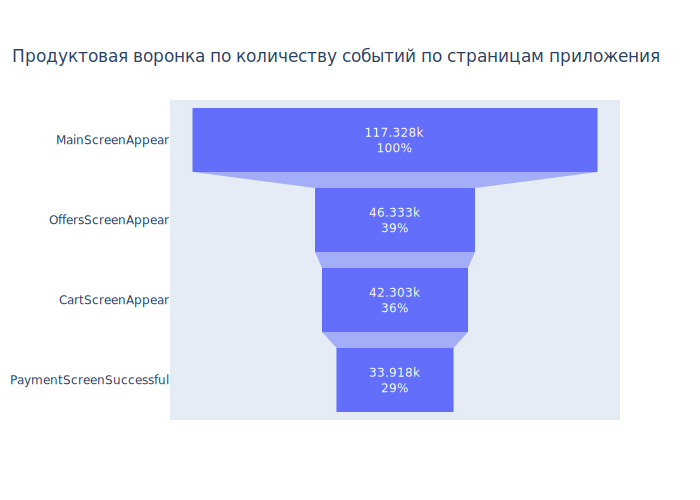

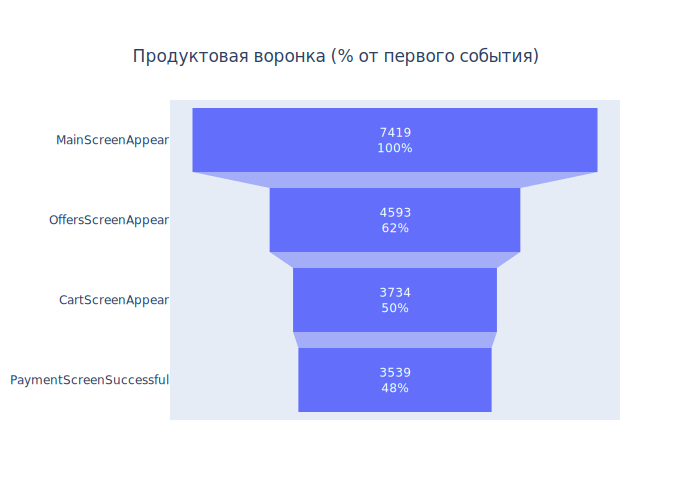

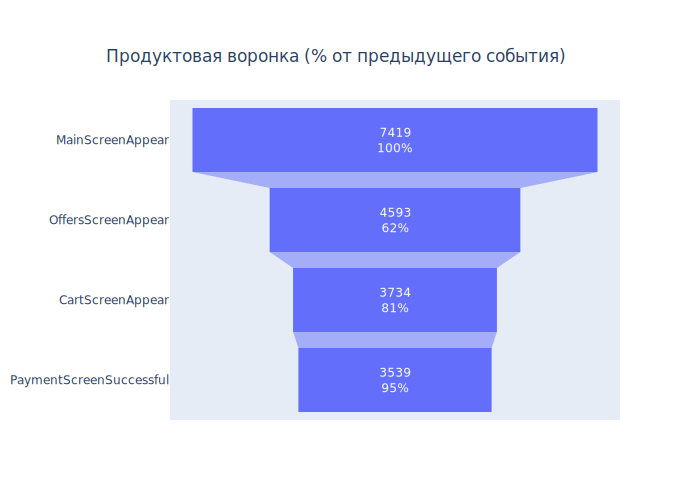

In [15]:
#Построим график
from plotly import graph_objects as go
fig = go.Figure(go.Funnel(
    y = eventNameCount["eventName"],
    x = eventNameCount['count'],
    textinfo = "value+percent initial"))
fig.update_layout(
    title={
        'text':'Продуктовая воронка по количеству событий по страницам приложения',
        'y':0.9,
        'x':0.48})
fig.show(renderer='svg')



fig = go.Figure(go.Funnel(
    y = eventNameCount["eventName"],
    x = eventNameCount['nunique'],
    textinfo = "value+percent initial"))
fig.update_layout(
    title={
        'text':'Продуктовая воронка (% от первого события)',
        'y':0.9,
        'x':0.48})
fig.show(renderer='svg')


fig = go.Figure(go.Funnel(
    y = eventNameCount["eventName"],
    x = eventNameCount['nunique'],
    textinfo = "value+percent previous"))
fig.update_layout(
    title={
        'text':'Продуктовая воронка (% от предыдущего события)',
        'y':0.9,
        'x':0.48})
fig.show(renderer='svg')

__Комментарий:__ <br>
Глядя на эту воронку мы видим, что больше всего пользователей (38%) уходят от нас посмотрев на главный экран(MainScreenAppear) и даже без перехода к каталогу товаров(OffersScreenAppear). 
Это может говорить о том что интерфейс основной страницы неудобен или некорректно отображается на части устройств, хорошо бы запросить данные о моделях устройств и проверить нет ли зависимости оттока пользователей от устройств.
От первого события до оплаты доходит меньше половины пользователей(всего 47%)

## 4. Анализ результатов эксперимента <a name="research_analysis"></a> 

Посчитаем сколько пользователей в каждой экспериментальной группе. Для этого создадим словарь, который выведет нам количество участников по каждом группе.

In [16]:
#Создалим словарь с количеством уникальных польхователей

n_users = {
           '246': logsExpNew[logsExpNew['expID']==246]['deviceID'].nunique(),
           '247': logsExpNew[logsExpNew['expID']==247]['deviceID'].nunique(),
           '248': logsExpNew[logsExpNew['expID']==248]['deviceID'].nunique(),
           '246+247': logsExpNew[(logsExpNew['expID']==246) | (logsExpNew['expID']==247)]['deviceID'].nunique()
          }

groups = ['246', '247', '248']

for g in groups:
    print('В {} находится {} человек'.format(g, n_users[g]))

В 246 находится 2483 человек
В 247 находится 2512 человек
В 248 находится 2535 человек


Нашей задачей является увеличение количества заказов, соответственно выручки. Поэтому сравним конверсии по действиям, то есть мы рассмотрим как у нас переходят пользователи с одной площадки воронки в следующую. Для этого мы по каждой группе найдем долю пользователей, которые  проходят на следующий шаг воронки.  Затем проведем __z-тест__. Для этого напишем функцию, которая будет нам проверять гипотезы о равенстве долей

In [17]:
#Посчитаем количество событий по группе 246
usersGroup246 = logsExpNew.query('expID == "246"')
eventNameCount246 = usersGroup246.groupby('eventName').agg({'deviceID': 'nunique'}).sort_values(by='deviceID', ascending=False).reset_index()

#Посчитаем количество событий по группе 247
usersGroup247 = logsExpNew.query('expID == "247"')
eventNameCount247 = usersGroup247.groupby('eventName').agg({'deviceID': 'nunique'}).sort_values(by='deviceID', ascending=False).reset_index()

#Посчитаем количество событий по группе 248
usersGroup248 = logsExpNew.query('expID == "248"')
eventNameCount248 = usersGroup248.groupby('eventName').agg({'deviceID': 'nunique'}).sort_values(by='deviceID', ascending=False).reset_index()

eventNameCountTotal = eventNameCount246.merge(eventNameCount247, on='eventName', suffixes=['_246','_247'])

#Создалим сводную таблицу по каждой эксперементальной группе 
eventNameCountTotal = eventNameCountTotal.merge(eventNameCount248, on='eventName')
eventNameCountTotal = eventNameCountTotal.rename(columns={'deviceID_246': '246', 'deviceID_247': '247', 'deviceID': '248'})
eventNameCountTotal['246+247'] = eventNameCountTotal['246'] + eventNameCountTotal['247']

eventNameCountTotal

,eventName,246,247,248,246+247
0,MainScreenAppear,2450,2476,2493,4926
1,OffersScreenAppear,1542,1520,1531,3062
2,CartScreenAppear,1266,1238,1230,2504
3,PaymentScreenSuccessful,1200,1158,1181,2358


In [18]:
#Прописываем функцию, которая нам будет считать Z-текст
def checking_z_value(alpha, first_group, second_group):
    alpha = alpha # критический уровень статистической значимости
    print('Нулевая гипотеза: отсутствует статистическая разница между долями группы ' + first_group + ' и группы ' + second_group) 
    print('')
    print('Ненулевая гипотеза: присутствует статистическая разница между долями группы ' + first_group + ' и группы ' + second_group) 
    print('')
    print(50*'-')
    for i in eventNameCountTotal.index:
        # пропорция успехов в первой группе:
        p1 = eventNameCountTotal[first_group][i]/n_users[first_group]
        
        # пропорция успехов во второй группе:
        p2 = eventNameCountTotal[second_group][i]/n_users[second_group]
        # пропорция успехов в комбинированном датасете:
        p_combined = (eventNameCountTotal[first_group][i] + eventNameCountTotal[second_group][i]) / (n_users[first_group] + n_users[second_group])
        # разница пропорций в датасетах
        difference = p1 - p2 

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(
             p_combined * (1 - p_combined) * (1 / n_users[first_group] + 1 /  n_users[second_group])
        )

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2

        print('{} p-значение: {}'.format(eventNameCountTotal['eventName'][i], p_value))
 
        if p_value < alpha:
           print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print(
              'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
             ) 
        print(50*'-')

#Прописываем функцию, которая будет рисовать нам график воронки     
def go_figure(first_group, second_group):
        fig = go.Figure()

        fig.add_trace(go.Funnel(
            name = first_group,
            y = eventNameCountTotal['eventName'],
            x = eventNameCountTotal[first_group],
            textposition = "inside",
            textinfo = "value+percent initial",
            connector = {"fillcolor": '#bde0eb'},
            insidetextfont = {'color': 'white', 'size': 14}))

        fig.add_trace(go.Funnel(
             name = second_group,
             y = eventNameCountTotal['eventName'],
             x = eventNameCountTotal[second_group],
             textposition = "inside",
             textinfo = "value+percent initial",
             connector = {"fillcolor": '#bde0eb'},
             insidetextfont = {'color': 'white', 'size': 14}))
        
        fig.update_layout(
            title={
                'text':'Сравнение воронок по двум группам: ' + first_group + ' и ' + second_group,
                'y':0.9,
                'x':0.48})
        fig.show(renderer='svg')

Проверим, находят ли статистические критерии разницу между выборками 246 и 247.

Нулевая гипотеза: отсутствует статистическая разница между долями группы 246 и группы 247

Ненулевая гипотеза: присутствует статистическая разница между долями группы 246 и группы 247

--------------------------------------------------
MainScreenAppear p-значение: 0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
OffersScreenAppear p-значение: 0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
CartScreenAppear p-значение: 0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
PaymentScreenSuccessful p-значение: 0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------


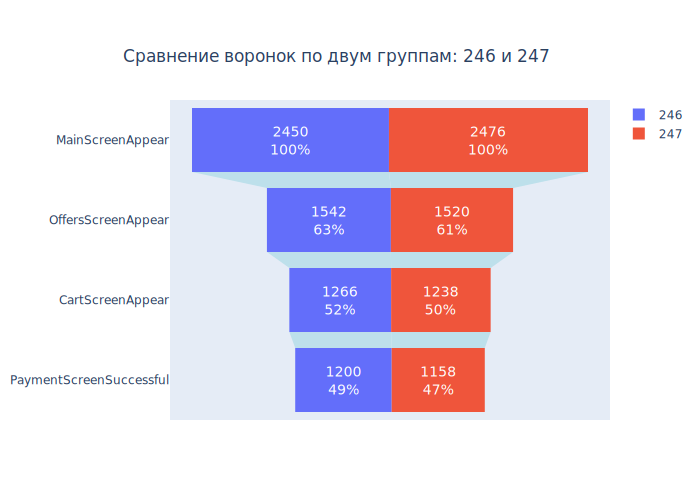

In [19]:
checking_z_value(0.05, '246', '247')
go_figure('246', '247')

__Комментарий:__<br>
Ни для оного из событий разница не оказалось значимой обе эти группы можно считать контрольными.

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию.
Группы 246 и 248:

Нулевая гипотеза: отсутствует статистическая разница между долями группы 246 и группы 248

Ненулевая гипотеза: присутствует статистическая разница между долями группы 246 и группы 248

--------------------------------------------------
MainScreenAppear p-значение: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
OffersScreenAppear p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
CartScreenAppear p-значение: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
PaymentScreenSuccessful p-значение: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------


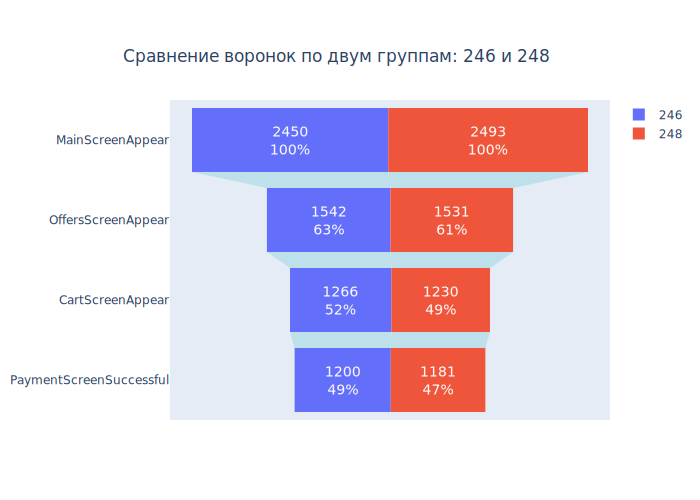

In [20]:
checking_z_value(0.05, '246', '248')
go_figure('246', '248')

Аналогично поступим с группой с изменённым шрифтом. Сравним результаты с каждой из контрольных групп в отдельности по каждому событию.
Группы 246 и 248:

Нулевая гипотеза: отсутствует статистическая разница между долями группы 246 и группы 248

Ненулевая гипотеза: присутствует статистическая разница между долями группы 246 и группы 248

--------------------------------------------------
MainScreenAppear p-значение: 0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
OffersScreenAppear p-значение: 0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
CartScreenAppear p-значение: 0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
PaymentScreenSuccessful p-значение: 0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------


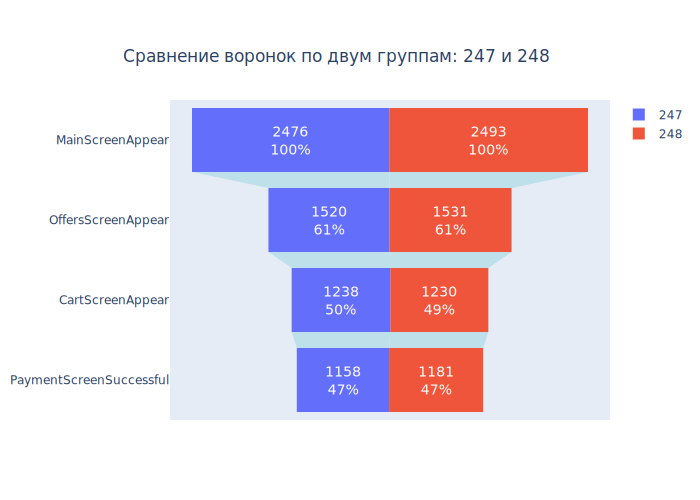

In [21]:
checking_z_value(0.05, '246', '248')
go_figure('247', '248')

__Комментарий:__<br>
Значимой разницы между контрольной группой 246 и экспериментальной группой не выявлено.

Группы 247 и 248:

Нулевая гипотеза: отсутствует статистическая разница между долями группы 247 и группы 248

Ненулевая гипотеза: присутствует статистическая разница между долями группы 247 и группы 248

--------------------------------------------------
MainScreenAppear p-значение: 0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
OffersScreenAppear p-значение: 0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
CartScreenAppear p-значение: 0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
PaymentScreenSuccessful p-значение: 0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------


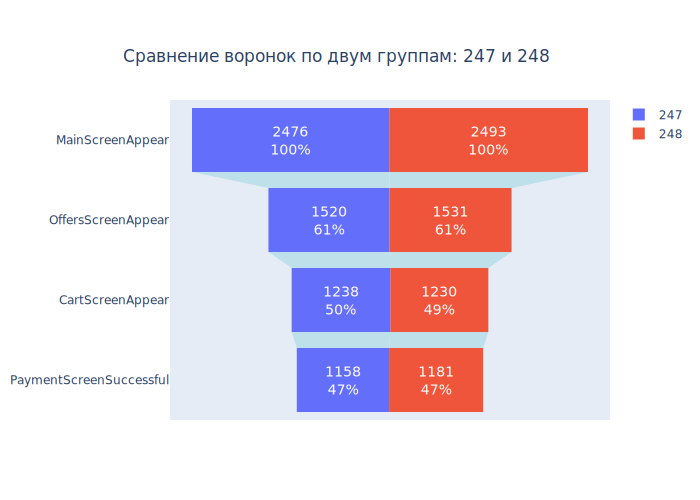

In [22]:
checking_z_value(0.05, '247', '248')
go_figure('247', '248')

__Комментарий:__<br>
Значимой разницы между контрольной группой 247 и экспериментальной группой не выявлено.

Теперь сравним контрольные 246 и 247, объединенные в одну группу, с экспериментальной 248-ой:

Нулевая гипотеза: отсутствует статистическая разница между долями группы 246+247 и группы 248

Ненулевая гипотеза: присутствует статистическая разница между долями группы 246+247 и группы 248

--------------------------------------------------
MainScreenAppear p-значение: 0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
OffersScreenAppear p-значение: 0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
CartScreenAppear p-значение: 0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------
PaymentScreenSuccessful p-значение: 0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
--------------------------------------------------


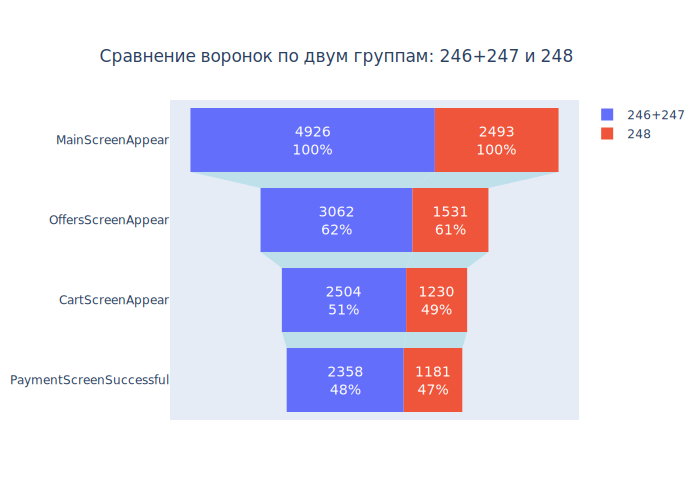

In [23]:
checking_z_value(0.05, '246+247', '248')
go_figure('246+247', '248')

__Комментарий:__<br>
Сравнение результатов с объединенной контрольной группой также не показало значимой разницы.

__Вывод:__<br>
<br>
Мы провели 16 проверок статистических гипотез с уровнем значимости 0.05 (12 из них проверяли разницу между контрольными группами и группой с изменённым шрифтом) и ни одна из них не выявила значимой разницы.

При уровне значимости 0.1 только одна из проверок покажет значимую разницу, между контрольной группой 246 и экспериментальной в доле перехода пользователей в корзину(CartScreenAppear), но эта разница будет не в пользу нашей экспериментальной группы. Но при уровне значимости 0.1 каждый десятый раз можно получать ложный результат, поэтому стоит применить изначально выбранный нами уровень значимости 0.05 или как вариант применить поправку Бонферрони. Данная поправка требует, чтобы уровень значимости ɑ был разделен на число гипотез. В данном случае число гипотез у нас равно 16, поэтому нужно значение __alpha__ разделить на 16 и получится значение 0,003.<br>
Поправку для множественных сравнений не имеет смысла применять, так как результаты и так выше 0.05. Проблема данной поправки в том, что практически невозможно отвергнуть нулевую гипотезу. На практике применяют более "мягкие" поправки для множественных сравнений. 

## 5. Выводы <a name="conclusion"></a> 

- Анализируя гистограмму по дате и времени, мы приняли решение отбросить неполные данные и оставить только период с 1 августа 2019 года.

- Только 98,5% всех пользователей хотя бы раз открывали главную страницу приложения (возможно оставшиеся пользователи не смогли попасть на главную страницу из-за ошибок/некорректной работы приложения).

- Только 4597 пользователей хотя бы раз открывали страницу с каталогом товаров (38% пользователей не увидели даже каталог товаров необходимо выяснить причину, возможно приложение не на всех устройствах работает корректно).

- Мы провели 16 проверок статистических гипотез с уровнем значимости 0.05 (12 из них проверяли разницу между контрольными группами и группой с изменённым шрифтом) и ни одна из них не выявила значимой разницы.

- При уровне значимости 0.1 ни одна из проверок не покажет значимой разницы. Но при уровне значимости 0.1 каждый десятый раз можно получать ложный результат, поэтому стоит применить изначально выбранный нами уровень значимости 0.05.

- Исходя из результатов данного A/A/B-эксперимента, мы можем судить, что на поведение пользователей изменение шрифта значимого эффекта не оказало. Что можно считать успехом, т.к. целью было узнать не отпугнут ли изменения пользователей. В то же время учитывая результаты эксперимента, если изменение шрифта не продиктовано проблемами в работе приложения, его можно не менять.